### 실습) "서울시_기간별_시간평균_대기환경_정보_2020.csv" 파일을 이용해서 '미세먼지 1시간(㎍/㎥)'를 예측하자. 데이터는 준비되어 있다.

모델 성능은 아래 그래프정도만 나와도 훌륭하다.

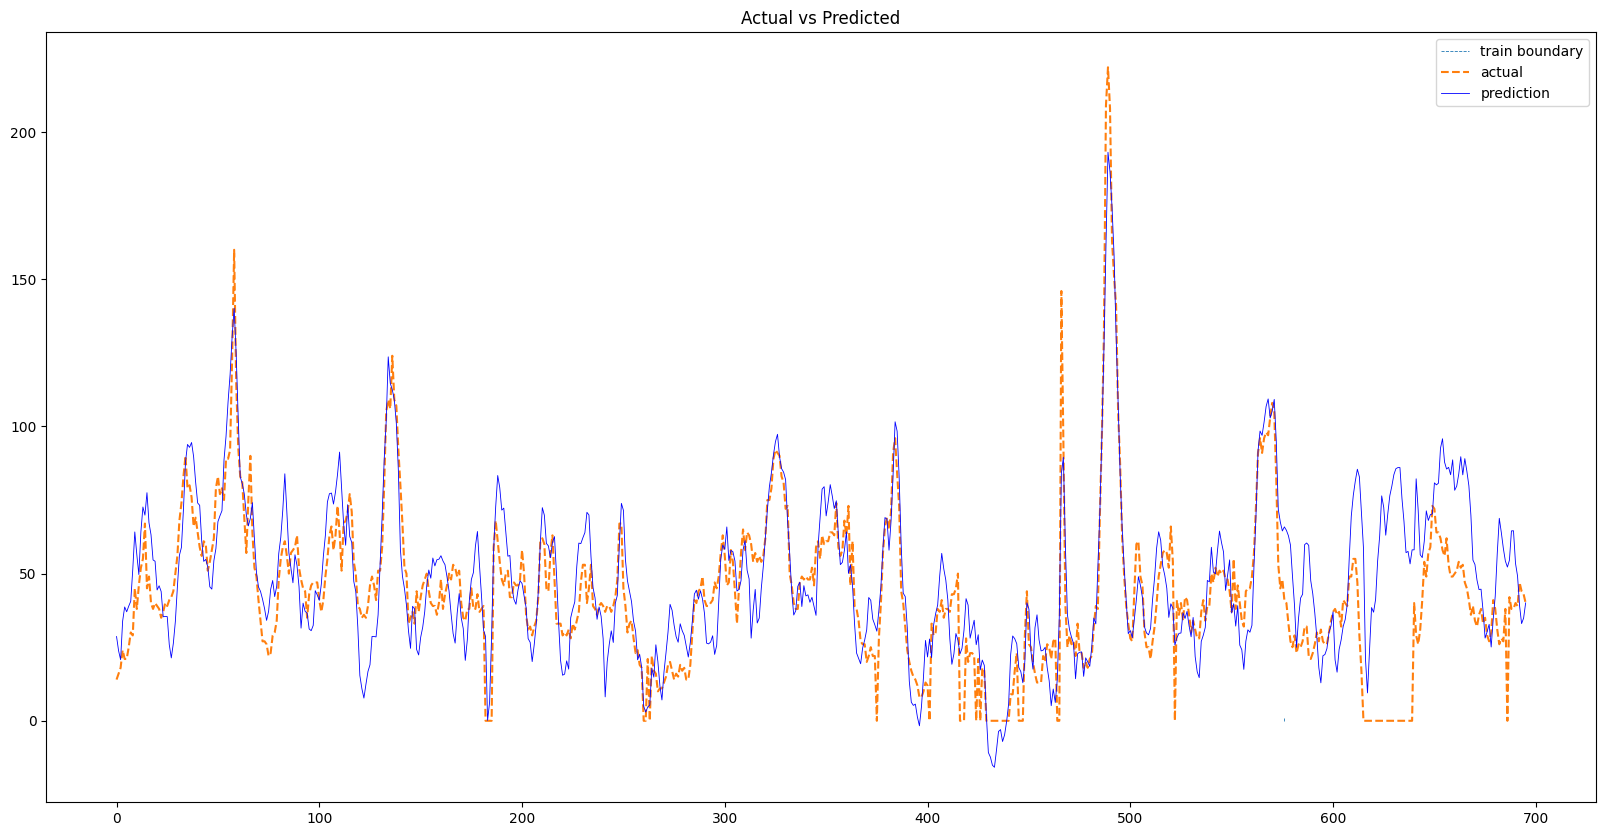

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = '서울시_기간별_시간평균_대기환경_정보_2020.04.csv'

                            # 인코딩이 깨지기 때문에 cp949 인코딩을 명시
df = pd.read_csv(file_path, encoding="cp949")

# '측정일시'를 datetime 형식으로 변환
df['측정일시'] = pd.to_datetime(df['측정일시'], format='%Y%m%d%H%M')

# 날짜가 거꾸로 되어있어서 '측정일시' 오름차순 정렬 (왜냐하면 미래를 예측할거니까)
df = df.sort_values(by='측정일시').reset_index(drop=True)

display(df)


,측정일시,권역코드,권역명,측정소코드,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm)
0,2020-04-01 00:00:00,104,동남권,111262,서초구,55,52,22,0.036,0.027,0.3,0.004
1,2020-04-01 00:00:00,100,도심권,111131,용산구,58,53,23,0.021,0.035,0.6,0.003
2,2020-04-01 00:00:00,100,도심권,111123,종로구,46,47,23,0.033,0.019,0.5,0.003
3,2020-04-01 00:00:00,100,도심권,111121,중구,44,44,24,0.032,0.020,0.4,0.003
4,2020-04-01 00:00:00,101,서북권,111201,마포구,48,43,23,0.014,0.043,0.6,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,2020-04-30 23:00:00,104,동남권,111261,강남구,32,34,23,0.046,0.008,0.4,0.002
17996,2020-04-30 23:00:00,104,동남권,111274,강동구,43,39,24,0.037,0.009,0.4,0.002
17997,2020-04-30 23:00:00,104,동남권,111262,서초구,40,42,28,0.057,0.006,0.2,0.002
17998,2020-04-30 23:00:00,102,동북권,111171,도봉구,35,36,21,0.048,0.010,0.3,0.003


In [ ]:
df['측정소명'].value_counts()

,count
측정소명,
서초구,720
동대문구,720
노원구,720
영등포구,720
금천구,720
관악구,720
도봉구,720
강서구,720
동작구,720


In [ ]:
# 서초구만 쓰자.
df = df.loc[df['측정소명']=="서초구"]
display(df)

,측정일시,권역코드,권역명,측정소코드,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm)
0,2020-04-01 00:00:00,104,동남권,111262,서초구,55,52,22,0.036,0.027,0.3,0.004
39,2020-04-01 01:00:00,104,동남권,111262,서초구,59,54,26,0.028,0.035,0.3,0.004
65,2020-04-01 02:00:00,104,동남권,111262,서초구,68,57,31,0.033,0.027,0.4,0.004
89,2020-04-01 03:00:00,104,동남권,111262,서초구,74,58,32,0.038,0.021,0.4,0.004
114,2020-04-01 04:00:00,104,동남권,111262,서초구,83,59,36,0.043,0.018,0.4,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...
17889,2020-04-30 19:00:00,104,동남권,111262,서초구,39,37,26,0.059,0.011,0.3,0.002
17916,2020-04-30 20:00:00,104,동남권,111262,서초구,47,38,26,0.054,0.010,0.3,0.002
17946,2020-04-30 21:00:00,104,동남권,111262,서초구,44,40,28,0.056,0.006,0.2,0.002
17968,2020-04-30 22:00:00,104,동남권,111262,서초구,43,41,25,0.055,0.007,0.2,0.002


{'whiskers': [<matplotlib.lines.Line2D at 0x7d86aa1c2e90>,
 'caps': [<matplotlib.lines.Line2D at 0x7d86aa1c1cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d86aa1c20b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7d86aa1c1870>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d86aa1c1450>],
 'means': []}

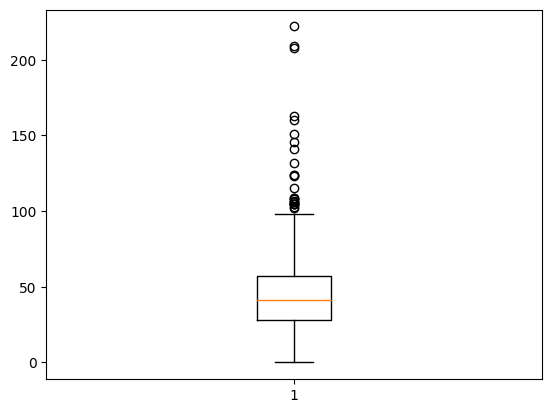

In [ ]:
plt.boxplot(df['미세먼지 1시간(㎍/㎥)'])

In [ ]:
df = df[['미세먼지 1시간(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)', '일산화탄소농도(ppm)', '아황산가스농도(ppm)']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 17997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   미세먼지 1시간(㎍/㎥)  720 non-null    int64  
 1   초미세먼지(㎍/㎥)     720 non-null    int64  
 2   오존(ppm)        720 non-null    float64
 3   이산화질소농도(ppm)   720 non-null    float64
 4   일산화탄소농도(ppm)   720 non-null    float64
 5   아황산가스농도(ppm)   720 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 39.4 KB


In [ ]:
X = df[['초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)', '일산화탄소농도(ppm)', '아황산가스농도(ppm)']].values
y = df['미세먼지 1시간(㎍/㎥)'].values

In [ ]:
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i: i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).view([-1, 1]).to(device)

sequence_length = 24  # 하루(24시간) 단위로 시퀀스 길이 설정

x_seq, y_seq = seq_data(X_scaled, y_scaled, sequence_length)

# 훈련 및 테스트 데이터 분할
split = int(len(df) * 0.8)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 32
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

input_size = x_seq.size(2)
hidden_size = 50
num_layers = 2

model = VanillaRNN(input_size, hidden_size, sequence_length, num_layers).to(device)


Epoch [1/100], Loss: 19.0611
Epoch [11/100], Loss: 11.8604
Epoch [21/100], Loss: 10.9459
Epoch [31/100], Loss: 10.3910
Epoch [41/100], Loss: 9.4861
Epoch [51/100], Loss: 9.9222
Epoch [61/100], Loss: 5.3067
Epoch [71/100], Loss: 4.4907
Epoch [81/100], Loss: 3.0841
Epoch [91/100], Loss: 4.0002


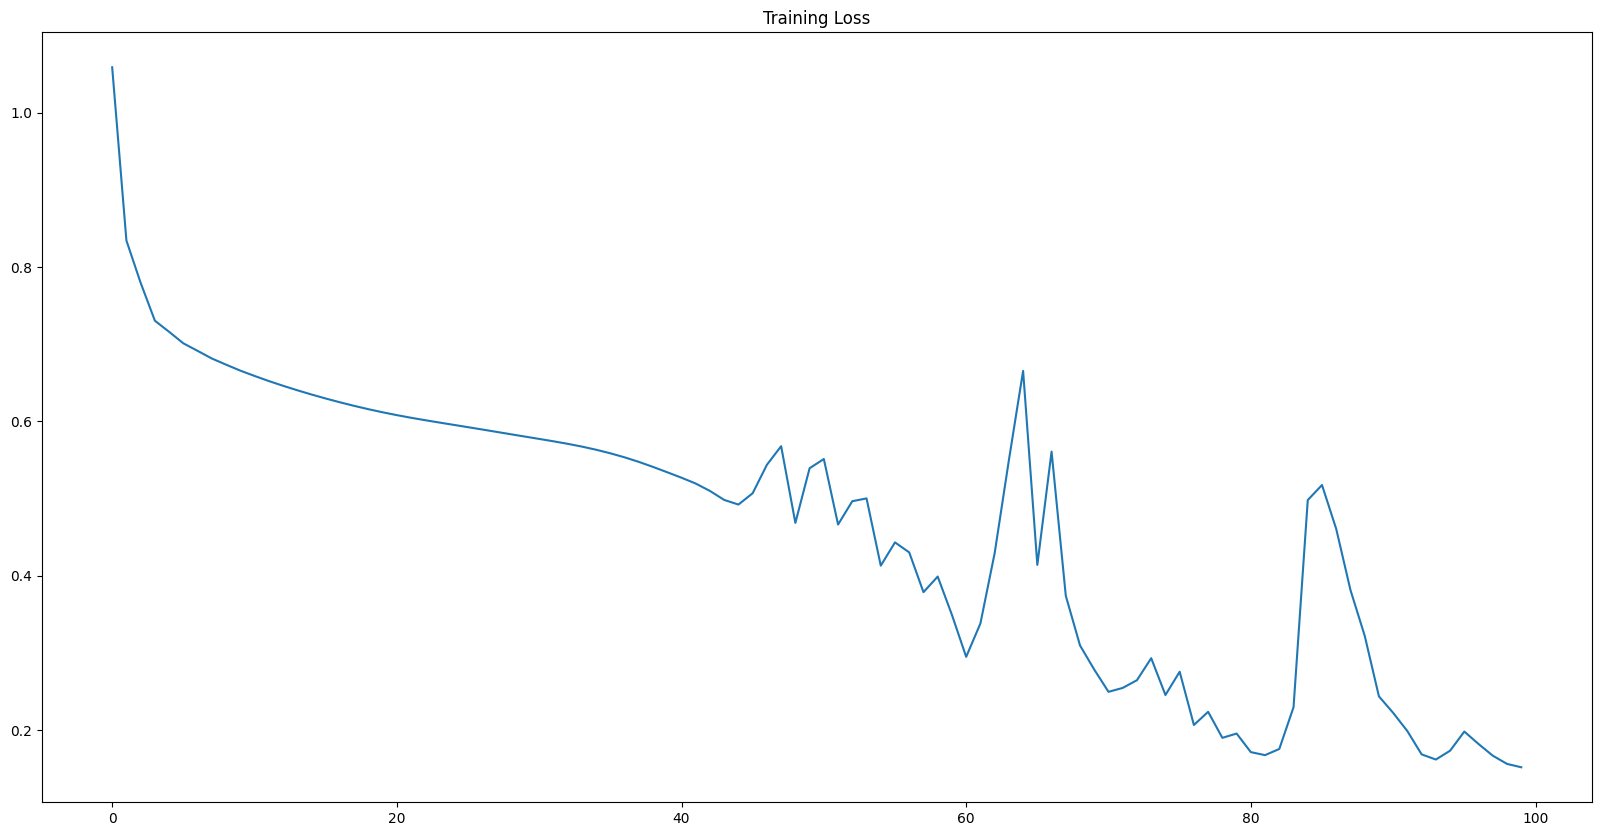

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
loss_graph = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')

# 손실 시각화
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.title('Training Loss')
plt.show()


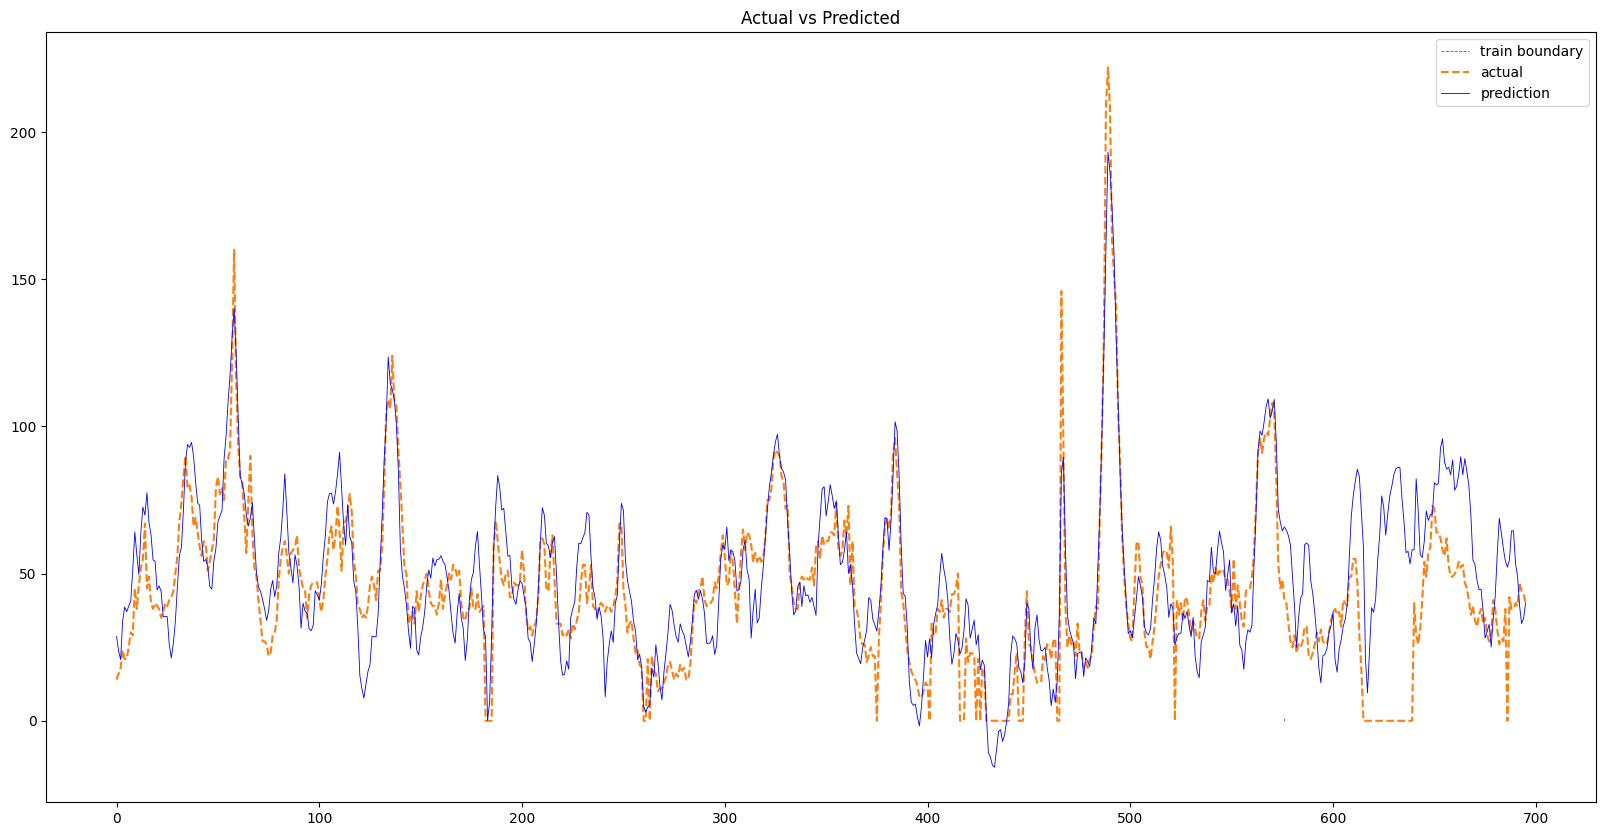

In [ ]:
actual = df['미세먼지 1시간(㎍/㎥)'][sequence_length:]

model.eval()
with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
        seq, _ = data
        out = model(seq)
        train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
        seq, _ = data
        out = model(seq)
        test_pred += out.cpu().numpy().tolist()

total = train_pred + test_pred
total_inverse = scaler_y.inverse_transform(total)

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(actual.values, '--', label='Actual')
plt.plot(total_inverse, 'b', linewidth=0.6, label='Prediction')
plt.title('Actual vs Predicted')
plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()